# BYOMBM Part 1: PBMetaD & FPS

Some Jupyter Magic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg
import os

In [2]:
%run Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
pbmetad_pool_size = 1000
fps_phase1_size = 500
fps_target_configs = 250

In [4]:
# pbmetad_pool_size = 100000
# fps_phase1_size = 30000
# fps_target_configs = 3000

In [5]:
if os.path.exists(scratch):
    scratch.remove()
if os.path.exists(restart):
    restart.remove()
if os.path.exists(structures):
    structures.remove()
scratch.create()
restart.create()
structures.create()

## Setup

Please uncomment one of these lines, depending on which monomer you want to do:

In [6]:
monomer_def_path = "fragment_COH2.def"
# monomer_def_path = "fragment_HCN.def"
# monomer_def_path = "fragment_NH4+.def"

Or, create a definition for your favorite small molecule!

In [7]:
# monomer_def_path = "fragment_HCN.def"

# my_custom_fragment_definition = BasicFragmentDefinition()

# C  = my_custom_fragment_definition.add_atom(AtomDefinition("C", "A"))
# H1 = my_custom_fragment_definition.add_atom(AtomDefinition("H", "B"))
# H2 = my_custom_fragment_definition.add_atom(AtomDefinition("H", "B"))
# H3 = my_custom_fragment_definition.add_atom(AtomDefinition("H", "B"))
# H4 = my_custom_fragment_definition.add_atom(AtomDefinition("H", "B"))

# my_custom_fragment_definition.add_bond(C, H1, BondDefinition(BondType.SINGLE))
# my_custom_fragment_definition.add_bond(C, H2, BondDefinition(BondType.SINGLE))
# my_custom_fragment_definition.add_bond(C, H3, BondDefinition(BondType.SINGLE))
# my_custom_fragment_definition.add_bond(C, H4, BondDefinition(BondType.SINGLE))

# write_fragment_definition(monomer_def_path, my_custom_fragment_definition)

In [25]:
calculator = Psi4Calculator(
        "HF",
        "STO-3G",
        log_directory=str(logs),
        scratch_directory=str(scratch.sub_directory("psi4")),
        qm_options={
            "GEOM_MAXITER": 500,
            "intrafrag_step_limit_max": 0.25
        }
)

In [9]:
definition_my_fragment = read_fragment_definition(definitions.file(monomer_def_path))
definition_water = read_fragment_definition(definitions.file("H2O.def"))

definition_monomer = BasicCompoundDefinition()
definition_monomer.add_fragment(definition_my_fragment)
write_definition(definitions.file("monomer.def"), definition_monomer)

definition_monomer_H2O = BasicCompoundDefinition()
definition_monomer_H2O.add_fragment(definition_water)
write_definition(definitions.file("monomer_H2O.def"), definition_monomer_H2O)

definition_dimer = BasicCompoundDefinition()
definition_dimer.add_fragment(definition_my_fragment)
definition_dimer.add_fragment(definition_water)
write_definition(definitions.file("dimer.def"), definition_dimer)

definition_trimer = BasicCompoundDefinition()
definition_trimer.add_fragment(definition_my_fragment)
definition_trimer.add_fragment(definition_water)
definition_trimer.add_fragment(definition_water)
write_definition(definitions.file("trimer.def"), definition_trimer)

In [10]:
system_initializer = VSEPRInitializer(seed=12345)

In [11]:
init_monomer = system_initializer(definition_monomer)
write_system(structures.file("initialized_monomer.xyz"), init_monomer)

Initializing compound C1O1H2
System initialization complete!


In [12]:
optimized_monomer, optimized_e, log_path = calculator.optimize(
        init_monomer,
        num_threads=16,
        mem_mb=16000,
        copier=CompoundCopier()
)

Optimizer: Optimization complete!


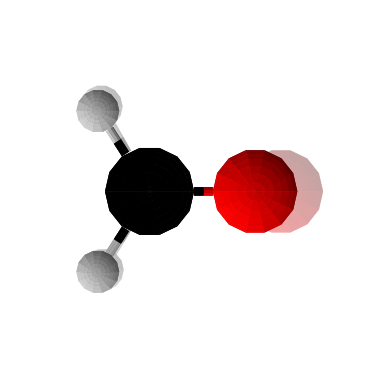

In [13]:
render_overlayed_systems(
    [init_monomer, optimized_monomer],
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=[0.2, 1.0]
)

In [14]:
write_system(structures.file("optimized_monomer.xyz"), optimized_monomer)

In [15]:
modes_monomer, log_path = calculator.normal_modes(
        optimized_monomer,
        num_threads=16,
        mem_mb=16000
)

In [16]:
write_vibrational_modes(structures.file("modes_monomer.modes"), modes_monomer)

In [17]:
optimized_water = read_system(definitions.file("monomer_H2O.def"), definitions.file("water.xyz"))

In [18]:
clusters_dimer = find_clusters(
        [optimized_monomer, optimized_water],
        calculator=calculator,
        num_guesses=5,
        restart_path=restart.sub_directory("clusters_2b"),
        guess_seed=123345,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 5 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 5 configurations.
Optimizer: Optimization complete!                                                                                            | - 0/5
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Optimizer: Optimization complete!
Minimizing geometries:  |====================================================================================================| - 5/5
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 5/5
Found 2 unique minimized clusters.


In [19]:
optimized_dimer = clusters_dimer[0]

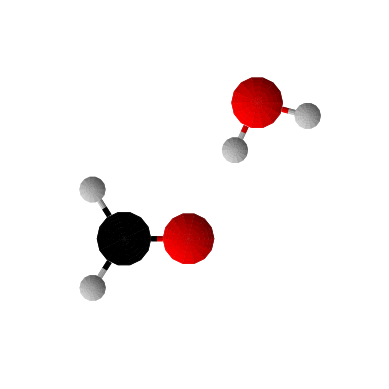

In [20]:
render_system(
    optimized_dimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[3].point)
)

In [21]:
write_system(structures.file("optimized_dimer.xyz"), optimized_dimer)

In [22]:
modes_dimer, log_path = calculator.normal_modes(
        optimized_dimer,
        num_threads=16,
        mem_mb=16000
)

In [23]:
write_vibrational_modes(structures.file("modes_dimer.modes"), modes_dimer)

In [26]:
clusters_trimer = find_clusters(
        [optimized_monomer, optimized_water, optimized_water],
        calculator=calculator,
        num_guesses=5,
        restart_path=restart.sub_directory("clusters_3b"),
        guess_seed=234234,
        radius=5,
        num_threads=16,
        mem_mb=32000,
        similarity_threshold=0.1,
        filter_by_hbonds=True,
        hbond_cut=3.0
)

Distance Distribution: dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Beginning random distance and rotation configuration generation.
Will generate 5 configs with distance distribution dist (A) = 5.0 * x + 0.0 for x in range [0,1].
Done! Generated 5 configurations.
Optimizer: Optimization complete!                                                                                            | - 0/5
Optimizer: Optimization complete!
Geometry minimization for system 3 failed!
Minimizing geometries:  |============================================================                                        | - 3/5
Maximum dynamic_level reached.


/expanse/projects/qstore/csd973/anaconda3/envs/qdms_tutorial_2/lib//python3.10/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/expanse/projects/qstore/csd973/anaconda3/envs/qdms_tutorial_2/lib//python3.10/site-packages/optking/stepAlgorithms.py:678: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[:-1, -1] = RFOmat[:-1, -1] / alpha**0.5
/expanse/projects/qstore/csd973/anaconda3/envs/qdms_tutorial_2/lib//python3.10/site-packages/optking/stepAlgorithms.py:684: RuntimeWarning: invalid value encountered in double_scalars
  scale_mat = np.diag(np.repeat(1 / alpha**0.5, dim1))
/expanse/projects/qstore/csd973/anaconda3/envs/qdms_tutorial_2/lib//python3.10/site-packages/optking/stepAlgorithms.py:677: RuntimeWarning: invalid value encountered in double_scalars
  SRFOmat[-1, :-1] = RFOmat[-1, :-1] / alpha**0.5
/expanse/projects/qstore/csd973/anaconda3/envs/qdms_tutoria

Optimizer: Optimization complete!
Minimizing geometries:  |====================================================================================================| - 5/5
Completed geometry minimizations!
Finding unique clusters:  |====================================================================================================| - 4/4
Found 4 unique minimized clusters.


In [27]:
optimized_trimer = clusters_trimer[0]

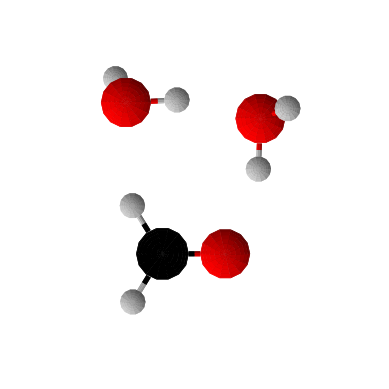

In [28]:
render_system(
    optimized_trimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[3].point)
)

In [29]:
write_system(structures.file("optimized_trimer.xyz"), optimized_trimer)

In [30]:
modes_trimer, log_path = calculator.normal_modes(
        optimized_trimer,
        num_threads=16,
        mem_mb=16000
)

 '334.0762' '353.4091' '451.7552' '543.2106']


In [31]:
write_vibrational_modes(structures.file("modes_trimer.modes"), modes_trimer)

## Monomer

In [32]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_monomer
)

In [33]:
bond_params

{('A', 'B'): (150, 1.2166938787095725), ('A', 'C'): (90, 1.1013804259847504)}

In [34]:
angle_params

{('B', 'A', 'C'): (10, 122.75038025053942),
 ('C', 'A', 'C'): (10, 114.49923826045027)}

In [35]:
nonbonded_params

{'A': (0.03, 2.2), 'B': (0.03, 2.2), 'C': (0.01, 1.2)}

In [36]:
charges = {atom.symmetry: 0.0 for atom in definition_monomer.atoms}

In [37]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_1b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_1b_scratch"),
        restart_path=restart.file("pbmetad_1b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [38]:
pbmetad_configs_monomer = perform_fps(
        definition_monomer,
        optimized_monomer,
        modes_monomer,
        structures.file("pbmetad_1b_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_1b_scratch"),
        restart_path=restart.sub_directory("fps_1b_restart"),
        num_threads=16
)

Number of permutations: 2
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 250/250
Completed round 1 fps, selected 250 configs, max distance: 0.23519495338912305
Number of permutations: 2
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 133
Completed round 2 fps, selected 133 configs.
Selected 383 total configs by FPS.


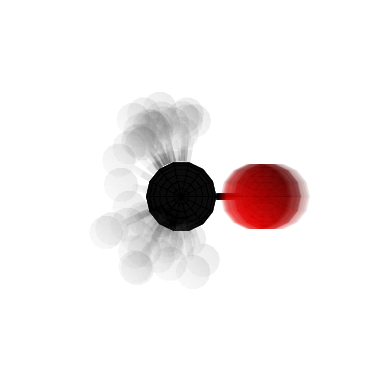

In [39]:
render_overlayed_systems(
    pbmetad_configs_monomer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Dimer

In [40]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_dimer
)

In [41]:
charges["E"] = 0.0
charges["F"] = 0.0

In [42]:
pbmetad_2b_size = 500

In [43]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_2b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_2b_scratch"),
        restart_path=restart.file("pbmetad_2b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [44]:
pbmetad_configs_dimer = perform_fps(
        definition_dimer,
        optimized_dimer,
        modes_dimer,
        structures.file("pbmetad_2b_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_2b_scratch"),
        restart_path=restart.sub_directory("fps_2b_restart"),
        num_threads=16
)

Number of permutations: 4
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 250/250
Completed round 1 fps, selected 250 configs, max distance: 1.5194068551175746
Number of permutations: 4
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 27
Completed round 2 fps, selected 27 configs.
Selected 277 total configs by FPS.


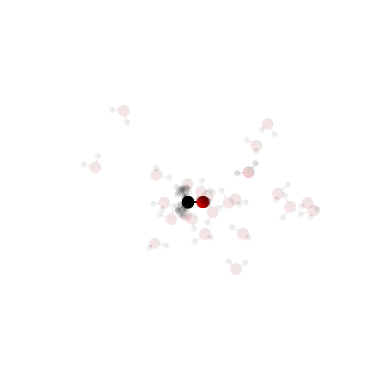

In [45]:
render_overlayed_systems(
    pbmetad_configs_dimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)

## Trimer

In [46]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        optimized_trimer
)

In [47]:
pbmetad_3b_size = 500

In [48]:
perform_pbmetad_simulation(
        "/expanse/projects/qstore/csd973/LAMMPS+plumed/LAMMPS-stable/bin/lmp_mpi",
        [optimized_monomer, optimized_water, optimized_water],
        num_configs=pbmetad_pool_size,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=structures.file("pbmetad_3b_traj.xyz"),
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=scratch.sub_directory("pbmetad_3b_scratch"),
        restart_path=restart.file("pbmetad_3b_restart")
)

Preparing PBMetaD Simulation...
Running PBMetaD Simulation...
Converting PBMetaD trajectory to XYZ...


In [49]:
pbmetad_configs_trimer = perform_fps(
        definition_trimer,
        optimized_trimer,
        modes_trimer,
        structures.file("pbmetad_3b_traj.xyz"),
        num_pool_configs=pbmetad_pool_size,
        num_phase1_input_configs=fps_phase1_size,
        approx_configs_to_select=fps_target_configs,
        fps_workdir=scratch.sub_directory("fps_3b_scratch"),
        restart_path=restart.sub_directory("fps_3b_restart"),
        num_threads=16
)

Number of permutations: 16
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 1 FPS...
BallTree built!
Performing round 1 FPS...
Round 1 FPS iterations: |====================================================================================================| - 250/250
Completed round 1 fps, selected 250 configs, max distance: 1.8830917225141541
Number of permutations: 16
Beginning featurization...
Featurization progress: |====================================================================================================| - 500/500
Featurized 500 configurations.
Initializing round 2 FPS...
BallTree built!
Performing round 2 FPS...
Round 2 FPS iterations: 51
Completed round 2 fps, selected 51 configs.
Selected 301 total configs by FPS.


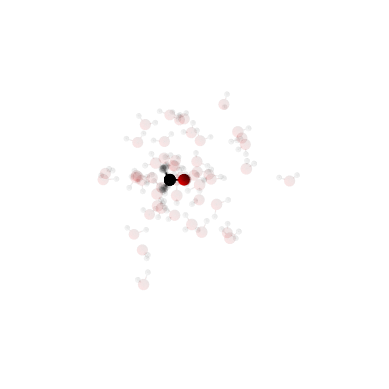

In [50]:
render_overlayed_systems(
    pbmetad_configs_trimer,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[1].point, system.atoms[2].point),
    alpha=0.05,
    num_to_show=25
)